In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import preprocess_input


In [9]:
# The path to content and style images
sentiment_image_path = './Sentiment_images/moody/download (2).jpeg'
content_image_path = './Content_images/Fsee5IYaAAAMc-5.jpeg'

def preprocess_data(path):
    img = load_img(
        path, target_size=(img_nrows, img_ncols)
    )
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


width, height = load_img(sentiment_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

""" The keras method of preprocessing images"""
senti_image = preprocess_data(sentiment_image_path)
content_image = preprocess_data(content_image_path)

senti_layers = ['block1_conv1', 'block2_conv1']
content_layer ='block5_conv2'

In [10]:
# Weights of the different loss components
total_variation_weight = 1e-1
senti_weight = 1e-7
content_weight = 1.0

result_name = "./senti/sentiment_gen"

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = tf.keras.applications.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [11]:
def MSEsenti_loss(senti_features, target_features):
    loss = tf.reduce_mean(tf.square(senti_features - target_features))
    return loss

# Similarity Based Loss
def similarity_basedloss(sentiment_features, transferred_features):
    # Compute the cosine similarity between sentiment features and transferred features
    sentiment_norm = tf.norm(sentiment_features, axis=1, keepdims=True)
    transferred_norm = tf.norm(transferred_features, axis=1, keepdims=True)
    cosine_similarity = tf.reduce_sum(sentiment_features * transferred_features, axis=1) / (sentiment_norm * transferred_norm)
    
    # Compute the sentiment loss as 1 - cosine similarity
    loss = 1 - cosine_similarity
    
    return loss

# Kullback-Leibler Divergence (KL Divergence) Loss
def kl_divergence_loss(sentiment_logits, transferred_logits):
    sentiment_probs = tf.nn.softmax(sentiment_logits)
    transferred_probs = tf.nn.softmax(transferred_logits)

    kl_divergence = tf.reduce_sum(sentiment_probs * tf.math.log(sentiment_probs / transferred_probs), axis=1)
    loss = tf.reduce_mean(kl_divergence)

    return loss


def content_loss(base, target):
    return tf.reduce_sum(tf.square(target - base))

# total variation loss,

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [12]:
def compute_loss(content_image, senti_image, target_image):
    input_tensor = tf.concat(
        [content_image, senti_image, target_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer]
    content_image_features = layer_features[0, :, :, :]
    target_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        content_image_features, target_features
    )
    # Add style loss
    for layer_name in senti_layers:
        layer_features = features[layer_name]
        senti_features = layer_features[1, :, :, :]
        target_features = layer_features[2, :, :, :]
        sl = MSEsenti_loss(senti_features, target_features)
        loss += (senti_weight / len(senti_layers)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(target_image)
    return loss

In [13]:
@tf.function
def compute_loss_and_gradients(content_image, senti_image, target_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(content_image, senti_image, target_image)
    grads = tape.gradient(loss, target_image)
    return loss, grads

 25%|██▌       | 50/200 [03:43<11:06,  4.44s/it]

Iteration 50: loss=1656976768.00


 50%|█████     | 100/200 [07:28<07:17,  4.37s/it]

Iteration 100: loss=1743249664.00


 75%|███████▌  | 150/200 [10:56<03:20,  4.00s/it]

Iteration 150: loss=1829584384.00


100%|██████████| 200/200 [14:36<00:00,  4.38s/it]

Iteration 200: loss=1775725824.00


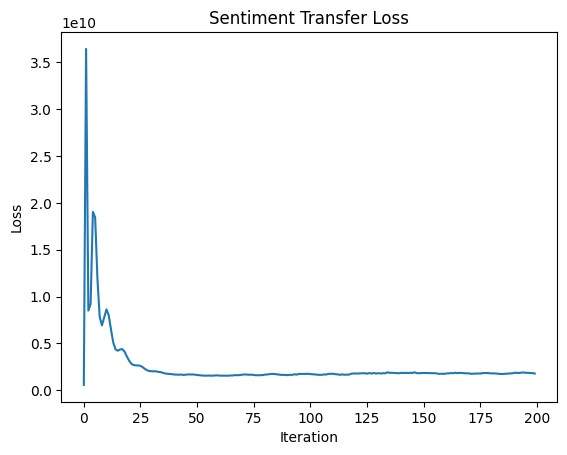

In [14]:
from tqdm import tqdm

optimizer = tf.keras.optimizers.legacy.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96)
)
target_image = tf.Variable(preprocess_data(content_image_path))
senti_resized = tf.image.resize(senti_image, (405, 512))

losses = []

iter = 200
for i in tqdm(range(1, iter + 1)):
    loss, grads = compute_loss_and_gradients(
        content_image, senti_image, target_image,
    )
    optimizer.apply_gradients([(grads, target_image)])

    losses.append(loss.numpy())

    # save image after every 1000 steps
    if i % 50 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(target_image.numpy())
        fname = result_name + "2_at_iteration_%d.png" % i
        tf.keras.preprocessing.image.save_img(fname, img)

# Plot the loss graph
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Sentiment Transfer Loss')
plt.show()

In [ ]:
# TODO.
# 1. Experiment with different weights (doing)
# 2. Experiment with different images (doing)
# 3. Try implementing SENTIGANS as well (or)
# 4. Merge with the style transfer.